In [1]:
import pandas as pd
import wandb
import matplotlib.pyplot as plt
import numpy as np
import os
import os.path as osp
import matplotlib

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

plt.style.use(["science", "ieee"])
api = wandb.Api()
out_dir = "../output/analysis_pnml_from_pretrained"
os.makedirs(out_dir, exist_ok=True)

# Project is specified by <entity/project-name>
runs = api.runs("kobybibas/pnml_for_dnn")


In [2]:
total_samples = 600

run_list = [
    "kobybibas/pnml_for_dnn/1gqa25gw",
    "kobybibas/pnml_for_dnn/3lz24pbf",
    "kobybibas/pnml_for_dnn/3oxo43jy",
    "kobybibas/pnml_for_dnn/3pipeird",
    "kobybibas/pnml_for_dnn/l6x0mrrb",
    "kobybibas/pnml_for_dnn/1z2g1mnf",
]
df_dict = {}
for run_name in run_list:
    run = api.run(run_name)
    run.file("res_df.pkl").download(replace=True)
    df = pd.read_pickle("res_df.pkl").iloc[:total_samples]
    df_dict[run_name] = df


In [3]:
performance_list = []
for prune_amount, df in df_dict.items():
    performance_list.append(
        {
            "Prune amount": prune_amount,
            "pNML accuracy (%)": 100 * df["pnml_is_correct"].mean(),
            "ERM accuracy (%)": 100 * df["erm_is_correct"].mean(),
            "pNML logloss": df["pnml_logloss"].mean(),
            "ERM logloss": df["erm_logloss"].mean(),
            "pNML max logloss": df["pnml_logloss"].max(),
            "ERM max logloss": df["erm_logloss"].max(),
            "Regret": df["pnml_regret"].mean(),
            "Test set size": len(df),
        }
    )

performance_df = pd.DataFrame(performance_list).round(2).set_index("Prune amount")
performance_df


,pNML accuracy (%),ERM accuracy (%),pNML logloss,ERM logloss,pNML max logloss,ERM max logloss,Regret,Test set size
Prune amount,,,,,,,,
kobybibas/pnml_for_dnn/1gqa25gw,67.52,76.43,1.12,0.90,11.09,9.97,0.12,314
kobybibas/pnml_for_dnn/3lz24pbf,67.52,76.43,1.12,0.90,11.09,9.97,0.12,314
kobybibas/pnml_for_dnn/3oxo43jy,67.52,76.43,1.12,0.90,11.09,9.97,0.12,314
kobybibas/pnml_for_dnn/3pipeird,76.50,75.67,0.94,1.01,12.58,13.66,0.05,600
kobybibas/pnml_for_dnn/l6x0mrrb,76.50,75.67,0.94,1.01,12.58,13.66,0.05,600
kobybibas/pnml_for_dnn/1z2g1mnf,70.17,74.17,0.97,0.97,10.15,11.57,0.03,600


In [22]:
# choose one
df = df_dict["kobybibas/pnml_for_dnn/3pipeird"]
prune_amount = 0.95
df.head(3)


,test_idx,pnml_nf,pnml_regret,pnml_logloss,pnml_is_correct,pnml_probs,genie_probs,erm_logloss,erm_is_correct,erm_probs,test_true_label
0,0,1.068246,0.066018,0.186523,True,"[6.63002792862244e-05, 0.0018751316238194704, ...","[7.082501542754471e-05, 0.002003102097660303, ...",0.078825,True,"[3.353482679813169e-05, 0.00044837043969891965...",3.0
1,1,1.149958,0.139726,0.384021,True,"[8.352938785094466e-09, 0.31888270378112793, 9...","[9.605529704970195e-09, 0.36670175194740295, 1...",0.113807,True,"[7.060864248842336e-08, 0.10756958276033401, 1...",8.0
2,2,1.005783,0.005767,0.010217,True,"[9.457359556108713e-05, 0.00861290842294693, 1...","[9.512053657090291e-05, 0.00866271834820509, 1...",0.009423,True,"[0.00018537092546466738, 0.007919787429273129,...",8.0


Max regret_max=0.987. Theoretical max: np.log(2)=0.693. Difference=regret_max-np.log(2)=0.29368078899114114 


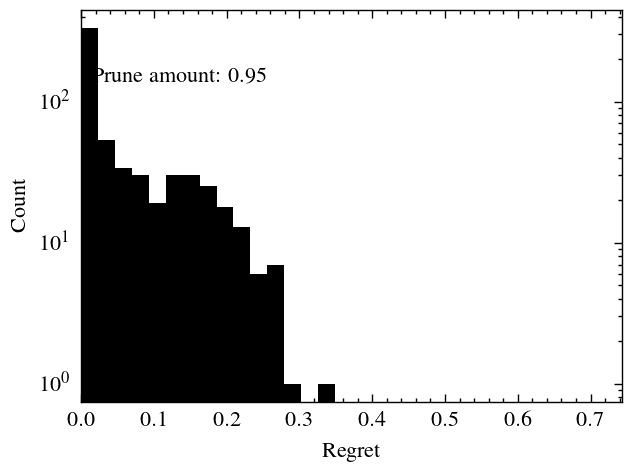

In [20]:
bins = np.linspace(0.0, np.log(10), 100)

regret_max = max([df["pnml_regret"].max() for df in df_dict.values()])
print(
    f"Max {regret_max=:.3f}. Theoretical max: {np.log(2)=:.3f}. Difference={regret_max-np.log(2)=} "
)
fig, ax = plt.subplots(1, 1, dpi=200, sharex=True, sharey=True)

ax.hist(
    df["pnml_regret"], bins=bins, alpha=1.0, color=f"C0",
)
ax.set_yscale("log")
ax.set_ylabel("Count")
ax.text(
    0.02,
    0.85,
    f"Prune amount: {float(prune_amount):3.2f}",
    ha="left",
    va="top",
    transform=ax.transAxes,
)
ax.set_xlabel("Regret")
plt.xlim(0, np.log(2) + 0.05)
plt.tight_layout()
plt.savefig(osp.join(out_dir, "regret_hist_from_pretrained.pdf"))
plt.show()


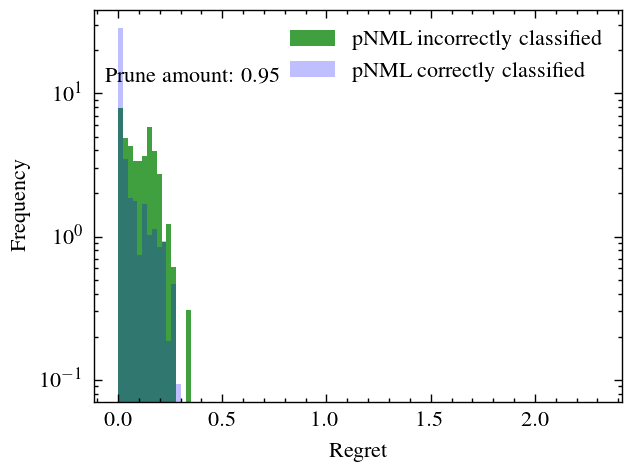

In [24]:
# Regret for pNML correctly classifed samples
bins = np.linspace(0.0, np.log(10), 100)
fig, ax = plt.subplots(1, 1, dpi=200, sharex=True, sharey=True)

regret_for_correct = df[df["pnml_is_correct"] == True]["pnml_regret"]
regret_for_incorrect = df[df["pnml_is_correct"] == False]["pnml_regret"]

ax.hist(
    regret_for_incorrect,
    bins=bins,
    alpha=0.75,
    color=f"C3",
    label="pNML incorrectly classified",
    density=True,
)
ax.hist(
    regret_for_correct,
    bins=bins,
    alpha=0.25,
    color=f"C2",
    label="pNML correctly classified",
    density=True,
)

ax.set_yscale("log")
ax.set_ylabel("Frequency")
ax.text(
    0.02,
    0.85,
    f"Prune amount: {float(prune_amount):3.2f}",
    ha="left",
    va="top",
    transform=ax.transAxes,
)
ax.set_xlabel("Regret")
ax.legend()
# ax.legend(
#     loc="upper center",
#     bbox_to_anchor=(0.5, 1.75),
#     frameon=True,
#     shadow=False,
#     ncol=2,
#     prop={"size": 6},
# )
# plt.xlim(0, np.log(2) + 0.05)
plt.tight_layout()
plt.savefig(
    osp.join(out_dir, "regret_hist_for_pnml_correct_and_incorrect_from_pretrained.pdf")
)
plt.show()


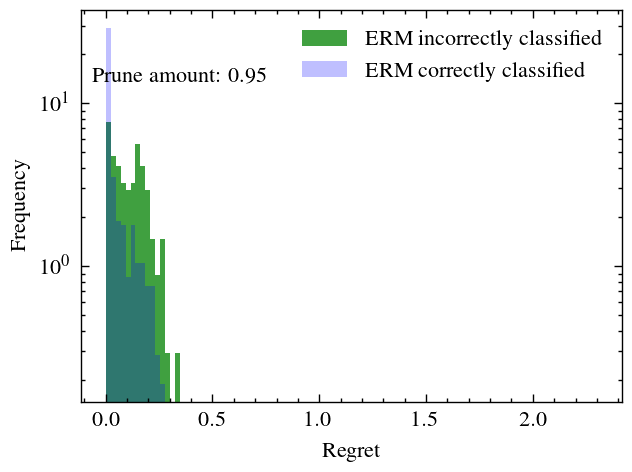

In [26]:
# Regret for ERM correctly classifed samples
bins = np.linspace(0.0, np.log(10), 100)
fig, ax = plt.subplots(1, 1, dpi=200, sharex=True, sharey=True)

regret_for_correct = df[df["erm_is_correct"] == True]["pnml_regret"]
regret_for_incorrect = df[df["erm_is_correct"] == False]["pnml_regret"]

ax.hist(
    regret_for_incorrect,
    bins=bins,
    alpha=0.75,
    color=f"C3",
    label="ERM incorrectly classified",
    density=True,
)
ax.hist(
    regret_for_correct,
    bins=bins,
    alpha=0.25,
    color=f"C2",
    label="ERM correctly classified",
    density=True,
)

ax.set_yscale("log")
ax.set_ylabel("Frequency")
ax.text(
    0.02,
    0.85,
    f"Prune amount: {float(prune_amount):3.2f}",
    ha="left",
    va="top",
    transform=ax.transAxes,
)
ax.set_xlabel("Regret")
ax.legend()
# plt.xlim(0, np.log(2) + 0.05)
plt.tight_layout()
plt.savefig(
    osp.join(out_dir, "regret_hist_for_erm_correct_and_incorrect_from_pretrained.pdf")
)
plt.show()


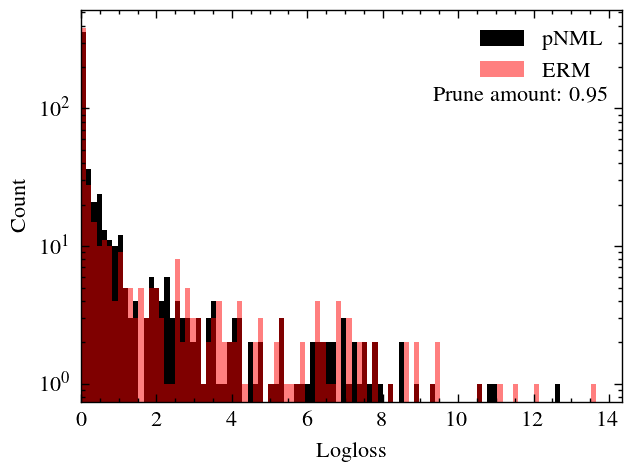

In [28]:
# Logloss
loss_max = max(
    [df["pnml_logloss"].max() for df in df_dict.values()]
    + [df["erm_logloss"].max() for df in df_dict.values()]
)
loss_min = min(
    [df["pnml_logloss"].min() for df in df_dict.values()]
    + [df["erm_logloss"].min() for df in df_dict.values()]
)

bins = np.logspace(-9, np.log10(loss_max), 100)
bins = np.linspace(0.0, loss_max, 100)


fig, ax = plt.subplots(1, 1, dpi=200, sharex=True, sharey=True)

ax.hist(
    df["pnml_logloss"], bins=bins, label=f"pNML", alpha=1.0, color="C0",
)
ax.hist(
    df["erm_logloss"], bins=bins, alpha=0.5, color="C1", label=f"ERM",
)

ax.text(
    0.975,
    0.8,
    f"Prune amount: {float(prune_amount):3.2f}",
    ha="right",
    va="top",
    transform=ax.transAxes,
)
ax.set_yscale("log")
ax.set_ylabel("Count")
ax.legend()
ax.set_xlabel(f"Logloss")
ax.set_xlim(left=0.0)
plt.tight_layout()
plt.savefig(osp.join(out_dir, "logloss_hist_from_pretrained.pdf"))
plt.show()


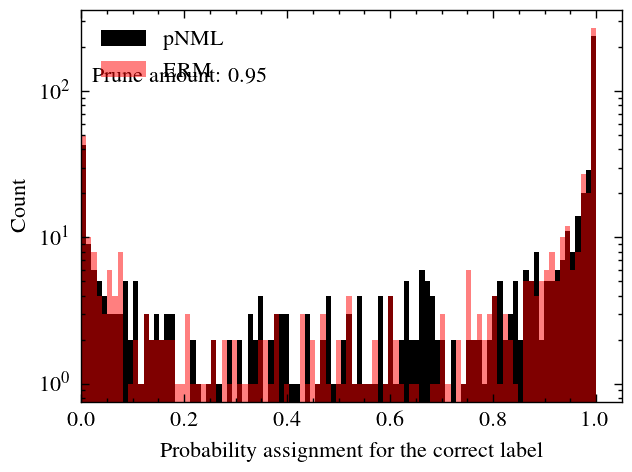

In [31]:
bins = np.linspace(0.0, 1.0, 100)


fig, ax = plt.subplots(1, 1, dpi=200, sharex=True, sharey=True)

pnml_probs_for_correct = df.apply(
    lambda row: row["pnml_probs"][int(row["test_true_label"])], axis=1
)
erm_probs_for_correct = df.apply(
    lambda row: row["erm_probs"][int(row["test_true_label"])], axis=1
)

ax.hist(
    pnml_probs_for_correct, bins=bins, label=f"pNML", alpha=1.0, color="C0",
)
ax.hist(
    erm_probs_for_correct, bins=bins, alpha=0.5, color="C1", label=f"ERM",
)

ax.text(
    0.02,
    0.85,
    f"Prune amount: {float(prune_amount):3.2f}",
    ha="left",
    va="top",
    transform=ax.transAxes,
)
ax.set_yscale("log")
ax.set_ylabel("Count")
ax.legend(
)
ax.set_xlabel(f"Probability assignment for the correct label")
ax.set_xlim(left=0.0)
plt.tight_layout()
plt.savefig(osp.join(out_dir, "prob_for_correct_label_hist_from_pretrained.pdf"))
plt.show()
